In [2]:
%pip install tensorflow

In [3]:
%pip install keras

In [4]:
#Descomprimo el archivo
import zipfile
file_name = "/content/animals.zip"

with zipfile.ZipFile(file_name, 'r') as zip_ref:
    zip_ref.extractall('./')  #Extraigo el contenido de la carpeta actual

In [5]:
#Creo una lista que representará las clases según índice
clases=["dog","horse","elephant","buttlerfly","chicken","cat","cow","sheep","spider","squirrel"]

In [6]:
#Cargo la data --> Uso ImageDataGenerator y flow_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
data_gen=ImageDataGenerator(
    rescale=1/255.,
    #dtype="int32", #Los valores serán del tipo int32
    validation_split=0.2, #El 20% de cada directorio donde se encuentran las clases, será para validation
)

In [7]:
#Ahora, genero la data para train y val a partir del data_gen
train_gen=data_gen.flow_from_directory(
    "animals", #Este es el nombre del directorio donde se encuentran las carpetas con las clases
    color_mode="rgb", #Las imágenes estarán en rgb, por lo que tendrán 3 canales
    target_size=(224,224), #Las imágenes serán de 224x224
    batch_size=20, #Batch para la data de train --> 20
    class_mode="sparse", #Aquí indico que los labels serán enteros
    subset="training", #Indico que será para train, pues el 20% restante deberá ser el subset de validation
)
#Lo mismo para val_gen, pero el subset será "validation". De tal forma que el 20% sea asignado a val_gen
val_gen=data_gen.flow_from_directory(
    "animals",
    color_mode="rgb",
    target_size=(224,224),
    batch_size=20,
    class_mode="sparse",
    subset="validation"
)

Found 20947 images belonging to 10 classes.
Found 5232 images belonging to 10 classes.


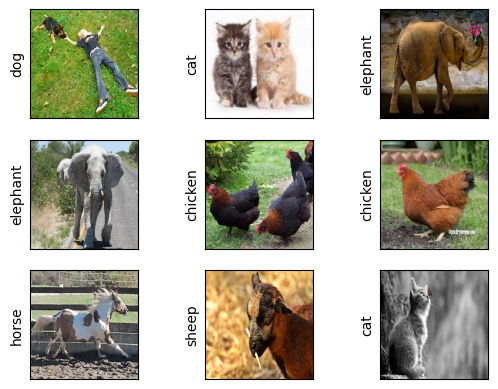

In [8]:
#Ahora, realizaré el plotteo de algunas imágenes
import matplotlib.pyplot as plt
for batch,labels_batch in train_gen:
    for i in range(9):
      plt.subplot(3,3,i+1)
      plt.xticks([]),plt.yticks([])
      plt.ylabel(clases[int(labels_batch[i])])
      plt.imshow(batch[i])
    break

In [30]:
#Cargo el modelo preentrenado de tensorflow.keras.applications
from tensorflow.keras.applications import vgg16
modelo=vgg16.VGG16(
    include_top=False,
    input_shape=(224,224,3),
    weights="imagenet"
)

Fine Tuning

In [31]:
#Inicialmente, establezco que todos los pesos de las capas del modelo puedan entrenarse (en el bucle determinaré cuáles no)
modelo.trainable=True
#Las 4 capas finales del modelo serán las que van a entrenarse
for layer in modelo.layers[:-4]:
  layer.trainable=False #Aquí coloco False, pues estas capas son las anteriores a las 4 finales y no serán entrenadas

In [32]:
modelo.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 7,079,424 (27.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [33]:
from tensorflow import keras
from tensorflow.keras import layers
#input=keras.Input((224,224,3))
#x=layers.Rescaling(1./255)(input)
x=modelo.output
x=layers.Flatten()(x)
x=layers.Dense(512,activation='relu')(x)
output=layers.Dense(10,activation='softmax')(x)
modelo=keras.Model(modelo.inputs,output) #modelo.inputs

In [34]:
modelo.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 27,565,386 (105.15 MB)

 Trainable params: 19,930,122 (76.03 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [35]:
#Optimizador
from tensorflow.keras.optimizers import Adam
optimizador=Adam(learning_rate=0.0001)

In [36]:
#Compile step
modelo.compile(
    optimizer=optimizador,
    loss="sparse_categorical_crossentropy", #labels int
    metrics=["accuracy"]
)

In [37]:
#Definiré 2 callbacks: ModelCheckpoint (para guardar el modelo) y EarlyStopping para parar el training antes de que se produzca el overfitting
from tensorflow.keras import callbacks
EarlyStopping=callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=15,
    restore_best_weights=True #Para almacen el modelo con mejores pesos antes de que ocurra el overfitting
)

ModelCheckpoint=callbacks.ModelCheckpoint(
    filepath="network_from_scratch.keras",
    monitor="val_accuracy",
    save_best_only=True, #Para guardar el modelo con mejor performance
)

In [38]:
#Entreno al modelo
history=modelo.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=[EarlyStopping,ModelCheckpoint],
    steps_per_epoch=80,
    validation_steps=80
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


80/80 ━━━━━━━━━━━━━━━━━━━━ 35s 266ms/step - accuracy: 0.4527 - loss: 1.6412 - val_accuracy: 0.7412 - val_loss: 0.7696
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 251ms/step - accuracy: 0.7747 - loss: 0.7173 - val_accuracy: 0.8062 - val_loss: 0.6000
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 19s 244ms/step - accuracy: 0.8138 - loss: 0.5541 - val_accuracy: 0.8163 - val_loss: 0.5618
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.8362 - loss: 0.4882

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 255ms/step - accuracy: 0.8363 - loss: 0.4880 - val_accuracy: 0.8380 - val_loss: 0.4787
Epoch 5/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 19s 243ms/step - accuracy: 0.8595 - loss: 0.4165 - val_accuracy: 0.8388 - val_loss: 0.4809
Epoch 6/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 19s 239ms/step - accuracy: 0.8797 - loss: 0.3621 - val_accuracy: 0.8431 - val_loss: 0.4553
Epoch 7/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 19s 244ms/step - accuracy: 0.8743 - loss: 0.3764 - val_accuracy: 0.8919 - val_loss: 0.3549
Epoch 8/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 13s 168ms/step - accuracy: 0.8825 - loss: 0.3494 - val_accuracy: 0.8958 - val_loss: 0.3218
Epoch 9/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 24s 299ms/step - accuracy: 0.8951 - loss: 0.3403 - val_accuracy: 0.8750 - val_loss: 0.3808
Epoch 10/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 18s 224ms/step - accuracy: 0.9156 - loss: 0.2800 - val_accuracy: 0.8763 - val_loss: 0.3673
Epoch 11/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 19s 241ms/step - accuracy: 0.9020 - loss: 0.3193 - val_accuracy: 0.8

In [39]:
#Cargo el modelo guardado
from tensorflow.keras.models import load_model
modelo_ft=load_model("network_from_scratch.keras")

In [41]:
#Evaluando el modelo
val_loss,val_acc=modelo_ft.evaluate(val_gen)

262/262 ━━━━━━━━━━━━━━━━━━━━ 28s 105ms/step - accuracy: 0.9138 - loss: 0.3394


In [43]:
print(f"Accuracy: {val_acc} y Loss: {val_loss}")

Accuracy: 0.9122706651687622 y Loss: 0.33523982763290405


Loss: 1.8712718486785889 y Accuracy: 0.8277904987335205 SIN FINE TUNING (solamente agregando 2 capas densas)